In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb

from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
def get_data(path):
    usecols = ['Country', 'EdLevel', 'YearsCodePro', 'Employment','Age', 'Gender', 'ConvertedCompYearly']
    data = pd.read_csv(path, usecols=usecols)
    data.rename(columns={"ConvertedCompYearly":"Salary"}, inplace=True)
    data = data.loc[~data.Salary.isna()]
    return data

def rmse(y_test, y_pred):
    return round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)

def train_evaluate(model, x_train, y_train, x_test, y_test):
    _ = model.fit(x_train, y_train)
    train_preds = model.predict(x_train)
    test_preds = model.predict(x_test)
    train_rmse = rmse(y_train, train_preds)
    test_rmse = rmse(y_test, test_preds)
    r2 = r2_score(y_test, test_preds)
    return train_rmse, test_rmse, r2

In [3]:
data = get_data('data/data.csv')

In [4]:
data.head()

,Employment,Country,EdLevel,YearsCodePro,Age,Gender,Salary
0,"Independent contractor, freelancer, or self-em...",Slovakia,"Secondary school (e.g. American high school, G...",NaN,25-34 years old,Man,62268.0
9,Employed full-time,Sweden,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",4,25-34 years old,Man,51552.0
11,Employed full-time,Spain,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",5,25-34 years old,Man,46482.0
12,Employed full-time,Germany,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",6,25-34 years old,Man,77290.0
16,Employed full-time,Turkey,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",2,25-34 years old,Man,17748.0


## Data Preprocessing

In [5]:
data.isna().sum()

Employment       13
Country           0
EdLevel          21
YearsCodePro    453
Age             109
Gender          175
Salary            0
dtype: int64

In [6]:
data.describe(include='all').fillna('-')

,Employment,Country,EdLevel,YearsCodePro,Age,Gender,Salary
count,46831,46844,46823,46391,46735,46669,46844.0
unique,5,171,9,52,8,16,-
top,Employed full-time,United States of America,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",3,25-34 years old,Man,-
freq,40627,9870,22510,4394,23284,43282,-
mean,-,-,-,-,-,-,118426.15289
std,-,-,-,-,-,-,527294.35529
min,-,-,-,-,-,-,1.0
25%,-,-,-,-,-,-,27025.0
50%,-,-,-,-,-,-,56211.0
75%,-,-,-,-,-,-,100000.0


In [7]:
### Removing Outliers

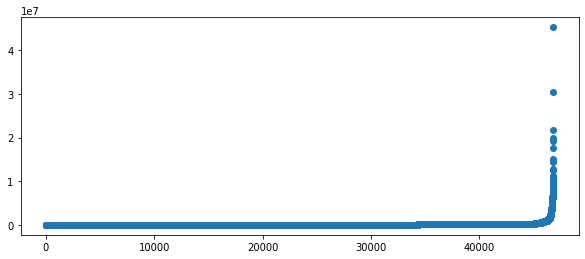

In [8]:
# Before
fig, ax = plt.subplots(1,1, figsize=(10,4))
_ = plt.scatter(x=range(len(data)), y=sorted(data.Salary))

In [9]:
data = data.loc[data.Salary <=200000]
data = data.loc[data.Salary>=4000]

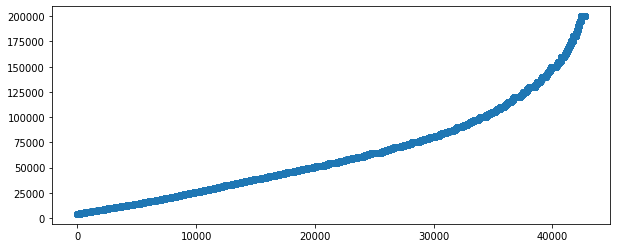

In [10]:
# After
fig, ax = plt.subplots(1,1, figsize=(10,4))
_ = plt.scatter(x=range(len(data)), y=sorted(data.Salary))

## Cleaning

In [11]:
# Employment

employment_dict = {
    'Employed full-time': 'full-time',
    'Employed part-time': 'part-time',
    'Independent contractor, freelancer, or self-employed': 'freelance',
    'I prefer not to say': 'other',
    'Retired': 'other'
}

def clip_employment(x):
    x = str(x)
    if x == 'Employed full-time':
        return 'full-time'
    elif x == 'Employed part-time': 
        return 'part-time'
    elif x == 'Independent contractor, freelancer, or self-employed':
        return 'freelance'
    else:
        return 'other'

data.Employment = data.Employment.apply(clip_employment)

In [12]:
# Country 
t1 = data.Country.value_counts()
most_freq = t1.loc[t1>500].index.tolist()

def clip_country(x):
    if x not in most_freq:
        return 'other'
    elif x == 'United States of America':
        return 'USA'
    elif x == 'United Kingdom of Great Britain and Northern Ireland':
        return 'UK'
    elif x == 'Russian Federation':
        return 'Russia'
    else:
        return x
data.Country = data.Country.apply(clip_country)

In [13]:
data.head()

,Employment,Country,EdLevel,YearsCodePro,Age,Gender,Salary
0,freelance,other,"Secondary school (e.g. American high school, G...",NaN,25-34 years old,Man,62268.0
9,full-time,Sweden,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",4,25-34 years old,Man,51552.0
11,full-time,Spain,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",5,25-34 years old,Man,46482.0
12,full-time,Germany,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",6,25-34 years old,Man,77290.0
16,full-time,Turkey,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",2,25-34 years old,Man,17748.0


In [14]:
# Ed Level

def clip_edlevel(x):
    x = str(x)
    if 'Bachelor’s degree' in x:
        return 'Bachelor’s degree'
    elif 'Master’s degree' in x:
        return 'Master’s degree'
    elif 'Some college/university' in x:
        return 'Some college'
    elif 'Other doctoral degree' in x:
        return 'Doctoral degree'
    elif 'Secondary school' in x:
        return 'Secondary school'
    elif 'Associate degree' in x:
        return 'Associate degree'
    elif 'Professional degree'in x:
        return 'Professional degree'
    elif 'Primary/elementary school' in x:
        return 'School'
    else: 
        return 'Other'
    
data.EdLevel = data.EdLevel.apply(clip_edlevel)

data.head()

,Employment,Country,EdLevel,YearsCodePro,Age,Gender,Salary
0,freelance,other,Secondary school,NaN,25-34 years old,Man,62268.0
9,full-time,Sweden,Master’s degree,4,25-34 years old,Man,51552.0
11,full-time,Spain,Bachelor’s degree,5,25-34 years old,Man,46482.0
12,full-time,Germany,Master’s degree,6,25-34 years old,Man,77290.0
16,full-time,Turkey,Bachelor’s degree,2,25-34 years old,Man,17748.0


In [15]:
# YearsCodePro
def clip_years_code(x):
    if x == 'More than 50 years':
        return 50.
    if x == 'Less than 1 year':
        return 0.5
    return float(x)

data.YearsCodePro = data.YearsCodePro.apply(clip_years_code)

median_exp = data.YearsCodePro.median()

data.YearsCodePro = data.YearsCodePro.fillna(value=median_exp)
data.head()

,Employment,Country,EdLevel,YearsCodePro,Age,Gender,Salary
0,freelance,other,Secondary school,6.0,25-34 years old,Man,62268.0
9,full-time,Sweden,Master’s degree,4.0,25-34 years old,Man,51552.0
11,full-time,Spain,Bachelor’s degree,5.0,25-34 years old,Man,46482.0
12,full-time,Germany,Master’s degree,6.0,25-34 years old,Man,77290.0
16,full-time,Turkey,Bachelor’s degree,2.0,25-34 years old,Man,17748.0


In [16]:
# Age
def clip_age(x):
    x = str(x)
    if x == '25-34 years old':
        return '25-34'
    elif x == '35-44 years old':
        return '35-44'
    elif x == '18-24 years old':
        return '18-24'
    elif x == '45-54 years old':
        return '45-54'
    elif x == '55-64 years old': 
        return '55-64'
    elif x == '65 years or older':
        return 'above 65'
    elif x == 'Under 18 years old':
        return 'below 18'
    else:
        return '25-34' #Most Frequent

data.Age = data.Age.map(clip_age)

In [17]:
data.head()

,Employment,Country,EdLevel,YearsCodePro,Age,Gender,Salary
0,freelance,other,Secondary school,6.0,25-34,Man,62268.0
9,full-time,Sweden,Master’s degree,4.0,25-34,Man,51552.0
11,full-time,Spain,Bachelor’s degree,5.0,25-34,Man,46482.0
12,full-time,Germany,Master’s degree,6.0,25-34,Man,77290.0
16,full-time,Turkey,Bachelor’s degree,2.0,25-34,Man,17748.0


In [18]:
# Gender
def clip_gender(x):
    x = str(x)
    if x == 'Man':
        return 'man'
    if x == 'Woman':
        return 'woman'
    return 'other'

data.Gender = data.Gender.apply(clip_gender)

In [19]:
data.head()

,Employment,Country,EdLevel,YearsCodePro,Age,Gender,Salary
0,freelance,other,Secondary school,6.0,25-34,man,62268.0
9,full-time,Sweden,Master’s degree,4.0,25-34,man,51552.0
11,full-time,Spain,Bachelor’s degree,5.0,25-34,man,46482.0
12,full-time,Germany,Master’s degree,6.0,25-34,man,77290.0
16,full-time,Turkey,Bachelor’s degree,2.0,25-34,man,17748.0


In [20]:
features = ['Employment', 'Country', 'EdLevel', 'Age', 'Gender', 'YearsCodePro']
target = 'Salary'

X = data[features]
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [21]:
X_train.shape, X_test.shape

((34192, 6), (8548, 6))

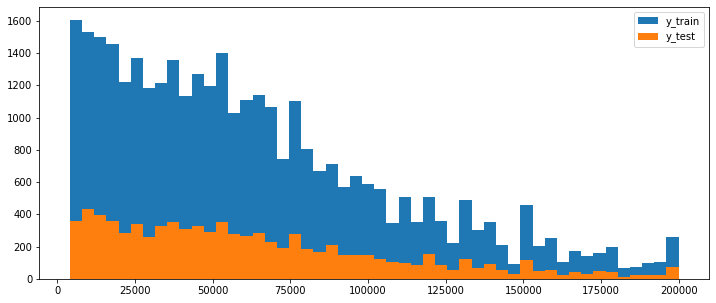

In [22]:
plt.figure(figsize=(12, 5))
plt.hist(y_train, label='y_train', bins=50)
plt.hist(y_test, label='y_test', bins=50)
plt.legend()
plt.show()

In [23]:
X_train.head()

,Employment,Country,EdLevel,Age,Gender,YearsCodePro
6014,part-time,Switzerland,Associate degree,35-44,man,14.0
56830,full-time,Brazil,Some college,25-34,man,4.0
81283,full-time,other,Bachelor’s degree,18-24,woman,0.5
15040,full-time,Sweden,Bachelor’s degree,25-34,man,8.0
5772,full-time,Spain,Bachelor’s degree,35-44,man,14.0


In [24]:
cat_cols = ['Employment','Country','EdLevel','Age','Gender']
encoder = OrdinalEncoder()

X_train[cat_cols] = encoder.fit_transform(X_train[cat_cols].values)
X_test[cat_cols] = encoder.transform(X_test[cat_cols].values)
X_train.head()

,Employment,Country,EdLevel,Age,Gender,YearsCodePro
6014,3.0,12.0,0.0,2.0,0.0,14.0
56830,1.0,1.0,8.0,1.0,0.0,4.0
81283,1.0,16.0,1.0,0.0,2.0,0.5
15040,1.0,11.0,1.0,1.0,0.0,8.0
5772,1.0,10.0,1.0,2.0,0.0,14.0


In [34]:
new_train = pd.concat([X_train, y_train], axis=1)
new_test = pd.concat([X_test, y_test], axis=1)

new_train.to_csv("data/clean_train.csv", index=False)
new_test.to_csv("data/clean_test.csv", index=False)

new_train.corr()['Salary'].sort_values(ascending=False)

Salary          1.000000
YearsCodePro    0.401261
Age             0.359426
Country         0.165944
Gender         -0.011096
EdLevel        -0.038315
Employment     -0.101124
Name: Salary, dtype: float64

In [26]:
# Model Selection

In [27]:
results = pd.DataFrame(columns=['model', 'train_rmse', 'test_rmse', 'r2_score'])

In [28]:
models = {
    'Linear Regression': LinearRegression(),
    'Lasso': Lasso(random_state=101),
    'SVR': SVR(degree=2),
    'Random Forest': RandomForestRegressor(random_state=101),
    'XGB Regressor': xgb.XGBRegressor(random_state=101),
    'LGBM Regressor': lgb.LGBMRegressor(random_state=101),
}

for i, key in enumerate(models):
    print(f"-----{key}------")
    model = models[key]
    train_rmse, test_rmse, r2 = train_evaluate(model, X_train, y_train, X_test, y_test)
    results.loc[i] = [key, train_rmse, test_rmse, r2]
    print('## test rmse:',test_rmse)
    del model
    print("\n")

-----Linear Regression------
## test rmse: 40443.08


-----Lasso------
## test rmse: 40443.1


-----SVR------
## test rmse: 45496.34


-----Random Forest------
## test rmse: 30970.18


-----XGB Regressor------
## test rmse: 29420.24


-----LGBM Regressor------
## test rmse: 29014.88




In [29]:
results

,model,train_rmse,test_rmse,r2_score
0,Linear Regression,40771.16,40443.08,0.200840
1,Lasso,40771.16,40443.10,0.200839
2,SVR,45837.20,45496.34,-0.011342
3,Random Forest,25344.44,30970.18,0.531367
4,XGB Regressor,27677.99,29420.24,0.577100
5,LGBM Regressor,28722.03,29014.88,0.588673


# Hyperparameter Tuning - LightGBM Regressor

In [30]:
def objective(trial):
    
    dtrain = lgb.Dataset(X_train, label=y_train)

    params = {
        "objective": "regression",
        "metric": "rmse",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    gbm = lgb.train(params, dtrain)
    preds = gbm.predict(X_test)
    pred_labels = np.rint(preds)
    accuracy = rmse(y_test, pred_labels)
    return accuracy

#####################################################
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    

##############################################
model = lgb.LGBMRegressor(**trial.params)
model.fit(X_train, y_train)
test_preds = model.predict(X_test)
print("tuned gbm test rmse:",rmse(y_test, test_preds))

[I 2022-02-23 22:40:53,691] A new study created in memory with name: no-name-1374f9a0-f5a4-47f9-9e2b-b74af3bade8e
[I 2022-02-23 22:40:54,314] Trial 0 finished with value: 29074.88 and parameters: {'lambda_l1': 8.826746644489053e-07, 'lambda_l2': 1.7971225403963267e-06, 'num_leaves': 61, 'feature_fraction': 0.7694732153492454, 'bagging_fraction': 0.9824135879362327, 'bagging_freq': 7, 'min_child_samples': 51}. Best is trial 0 with value: 29074.88.
[I 2022-02-23 22:40:54,551] Trial 1 finished with value: 29079.56 and parameters: {'lambda_l1': 3.083139538378454e-08, 'lambda_l2': 4.637838062033861e-05, 'num_leaves': 15, 'feature_fraction': 0.5860540785438106, 'bagging_fraction': 0.44587549049586284, 'bagging_freq': 6, 'min_child_samples': 79}. Best is trial 0 with value: 29074.88.
[I 2022-02-23 22:40:55,476] Trial 2 finished with value: 29139.72 and parameters: {'lambda_l1': 0.11279543712851135, 'lambda_l2': 0.1888686203817432, 'num_leaves': 166, 'feature_fraction': 0.7953711048590095, 'ba

[I 2022-02-23 22:41:07,074] Trial 24 finished with value: 29057.46 and parameters: {'lambda_l1': 0.0006943131359380839, 'lambda_l2': 1.943147197885324, 'num_leaves': 25, 'feature_fraction': 0.5654672402082495, 'bagging_fraction': 0.8535205249285364, 'bagging_freq': 4, 'min_child_samples': 94}. Best is trial 15 with value: 29024.05.
[I 2022-02-23 22:41:07,641] Trial 25 finished with value: 29098.39 and parameters: {'lambda_l1': 0.07342150016128172, 'lambda_l2': 0.08385512935943253, 'num_leaves': 81, 'feature_fraction': 0.5314864912969288, 'bagging_fraction': 0.7403179585195818, 'bagging_freq': 4, 'min_child_samples': 46}. Best is trial 15 with value: 29024.05.
[I 2022-02-23 22:41:07,880] Trial 26 finished with value: 30895.37 and parameters: {'lambda_l1': 1.2324333169358188e-05, 'lambda_l2': 0.001571571154853914, 'num_leaves': 3, 'feature_fraction': 0.4286187631900367, 'bagging_fraction': 0.9510991806546172, 'bagging_freq': 3, 'min_child_samples': 56}. Best is trial 15 with value: 29024

[I 2022-02-23 22:41:17,757] Trial 48 finished with value: 28947.45 and parameters: {'lambda_l1': 2.3661111346239096e-07, 'lambda_l2': 3.9310142620393846, 'num_leaves': 29, 'feature_fraction': 0.8736372274788973, 'bagging_fraction': 0.9305705497753556, 'bagging_freq': 2, 'min_child_samples': 58}. Best is trial 44 with value: 28918.18.
[I 2022-02-23 22:41:18,728] Trial 49 finished with value: 29278.82 and parameters: {'lambda_l1': 7.850186079157507e-07, 'lambda_l2': 3.2924576547687267e-07, 'num_leaves': 164, 'feature_fraction': 0.7715087353114891, 'bagging_fraction': 0.8858619032029312, 'bagging_freq': 7, 'min_child_samples': 51}. Best is trial 44 with value: 28918.18.
[I 2022-02-23 22:41:19,012] Trial 50 finished with value: 28988.33 and parameters: {'lambda_l1': 1.775747043498989e-08, 'lambda_l2': 0.10260782200076328, 'num_leaves': 14, 'feature_fraction': 0.5844825867482482, 'bagging_fraction': 0.9436192835654184, 'bagging_freq': 1, 'min_child_samples': 81}. Best is trial 44 with value

[I 2022-02-23 22:41:28,031] Trial 72 finished with value: 28931.17 and parameters: {'lambda_l1': 6.241878147691675e-08, 'lambda_l2': 1.0865129583367141, 'num_leaves': 26, 'feature_fraction': 0.7248396158805476, 'bagging_fraction': 0.888949408293375, 'bagging_freq': 1, 'min_child_samples': 56}. Best is trial 44 with value: 28918.18.
[I 2022-02-23 22:41:28,328] Trial 73 finished with value: 28966.13 and parameters: {'lambda_l1': 3.3488561213075983e-07, 'lambda_l2': 0.764065820179787, 'num_leaves': 16, 'feature_fraction': 0.6782823369939761, 'bagging_fraction': 0.9347297770617237, 'bagging_freq': 1, 'min_child_samples': 70}. Best is trial 44 with value: 28918.18.
[I 2022-02-23 22:41:28,788] Trial 74 finished with value: 28932.54 and parameters: {'lambda_l1': 1.1537689528808858e-06, 'lambda_l2': 4.549255562358605, 'num_leaves': 31, 'feature_fraction': 0.7198599788769946, 'bagging_fraction': 0.9530611437134657, 'bagging_freq': 2, 'min_child_samples': 59}. Best is trial 44 with value: 28918.

[I 2022-02-23 22:41:39,022] Trial 96 finished with value: 28961.93 and parameters: {'lambda_l1': 1.5385133267824176e-08, 'lambda_l2': 0.02400712668842188, 'num_leaves': 45, 'feature_fraction': 0.628094803603048, 'bagging_fraction': 0.9228040361656236, 'bagging_freq': 2, 'min_child_samples': 65}. Best is trial 81 with value: 28907.87.
[I 2022-02-23 22:41:39,382] Trial 97 finished with value: 29013.62 and parameters: {'lambda_l1': 1.4272036921595824e-07, 'lambda_l2': 6.0205455867938085, 'num_leaves': 30, 'feature_fraction': 0.521358886489239, 'bagging_fraction': 0.9771584294994816, 'bagging_freq': 1, 'min_child_samples': 54}. Best is trial 81 with value: 28907.87.
[I 2022-02-23 22:41:39,743] Trial 98 finished with value: 28995.48 and parameters: {'lambda_l1': 1.2698684507375572e-05, 'lambda_l2': 1.368953132299385, 'num_leaves': 14, 'feature_fraction': 0.6848573784491574, 'bagging_fraction': 0.9949292315607047, 'bagging_freq': 2, 'min_child_samples': 73}. Best is trial 81 with value: 2890

Number of finished trials: 100
Best trial:
  Value: 28907.87
  Params: 
    lambda_l1: 8.71490803455367e-08
    lambda_l2: 0.030269319353668448
    num_leaves: 24
    feature_fraction: 0.7524414568377088
    bagging_fraction: 0.8726174272735052
    bagging_freq: 2
    min_child_samples: 61
[LightGBM] [Warning] feature_fraction is set=0.7524414568377088, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7524414568377088
[LightGBM] [Warning] lambda_l1 is set=8.71490803455367e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.71490803455367e-08
[LightGBM] [Warning] bagging_fraction is set=0.8726174272735052, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8726174272735052
[LightGBM] [Warning] lambda_l2 is set=0.030269319353668448, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.030269319353668448
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
tuned gbm test rmse: 2890

# Error Analysis

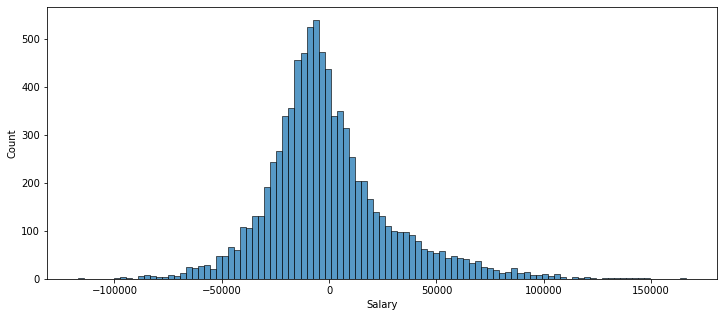

In [31]:
fig, ax = plt.subplots(1,1, figsize=(12,5))
_ = sns.histplot(y_test-test_preds, ax=ax)

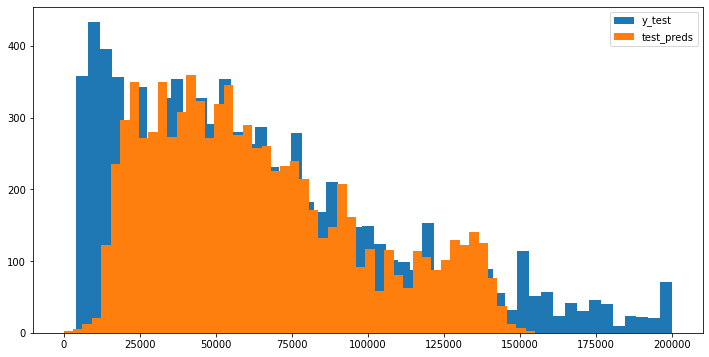

In [32]:
plt.figure(figsize=(12, 6))
plt.hist(y_test, label='y_test', bins=50)
plt.hist(test_preds, label='test_preds', bins=50)
plt.legend()
plt.show()

# Post Processing

In [33]:
import pickle
with open('artifacts/encoder.pkl', 'wb') as f:
    pickle.dump(encoder, f)

with open('artifacts/model.pkl', 'wb') as f:
    pickle.dump(model, f)
    
####################################################

with open('artifacts/encoder.pkl', 'rb') as f:
    encoder = pickle.load(f)

with open('artifacts/model.pkl', 'rb') as f:
    model = pickle.load(f)

def predict(x):
    x = np.array(x).reshape(1, -1)
    x[:, :-1] = encoder.transform(x[:, :-1])
    x = np.float32(x)
    y = model.predict(x)
    return round(y[0],2)

#####################################################

iput = ['freelance', 'other','Secondary school','25-34','man','7.0']
predict(iput)

53148.67